# Ignoring outliers

Here we show an example of when you may want to ignore outlying data when rescaling parameters. We recommend first understand [this notebook](https://github.com/jtiosue/rcal/blob/main/examples/rcal-overview.ipynb).

In [1]:
import rcal

Let's start as usual. Consider the following *training* data; that is, data that we use to calibrate the parameters of our model:

In [2]:
train_data = {
    ('r1', 'p1', 0): 4,
    ('r1', 'p2', 0): 5,
    ('r1', 'p3', 2): 5,
    ('r1', 'p3', 3): 4,
    ('r1', 'p4', 0): 1,
    ('r1', 'p5', 0): 3,
    ('r1', 'p6', 0): 2,
    
    ('r2', 'p3', 0): 4.5,
    ('r2', 'p1', 0): 4,
    ('r2', 'p2', 2): 5,
    ('r2', 'p2', 3): 4,
    ('r2', 'p4', 3): 1,
    ('r2', 'p4', 2): 1,
    ('r2', 'p5', 0): 3,
    ('r2', 'p6', 1): 2,
    
    ('r3', 'p2', 0): 2,
    ('r3', 'p2', 1): 1,
    ('r3', 'p1', 0): 1,
    ('r3', 'p1', 2): 2,
    ('r3', 'p3', 2): 2,
    ('r3', 'p3', 3): 1,
    ('r3', 'p3', 4): 1
}
cp = rcal.calibrate_parameters(train_data)
cp.rescale_parameters(train_data, bounds=(1, 5))

Notice that reviewer 3 only ever rates with 1 and 2 stars while reviewers 1 and 2 often rate with 4 and 5 stars. It follows that, upon calibration, reviewer 3's calibration will substantially boost their raw ratings. We can see this by plotting the calibration curves (see [this notebook](https://github.com/jtiosue/rcal/blob/main/examples/rcal-overview.ipynb) for details about these plots).

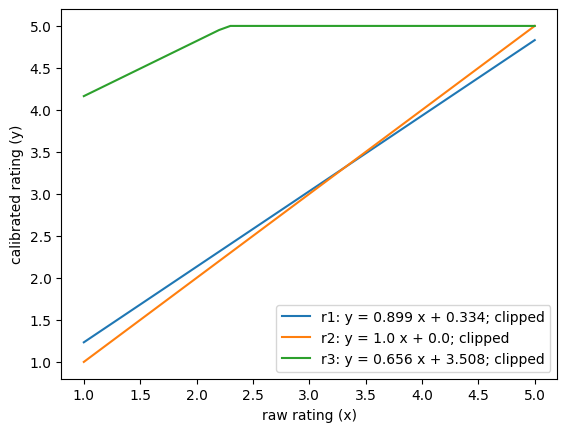

In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('raw rating (x)')
plt.ylabel('calibrated rating (y)')
xs = [x/10. for x in range(10, 51)]
for r in ('r1', 'r2', 'r3'):
    ar = round(cp.reviewer_scale(r), 3)
    br = round(cp.reviewer_offset(r), 3)
    plt.plot(
        xs, [cp.calibrate_rating(r, x, clip_endpoints=(1, 5)) for x in xs], 
        label=f"{r}: y = {ar} x + {br}; clipped"
    )
plt.legend()
plt.show()

Suppose that we now have some new ratings.

In [4]:
data = train_data.copy()
data[('r3', 'p1', 1)] = 5

Recall that reviewer only ever rated with 1 and 2 stars in the training data, whereas now all of the suddent they have rated somebody with 5 stars! As a result, if we rescale the parameters with `data`, we will a very skewed scale.

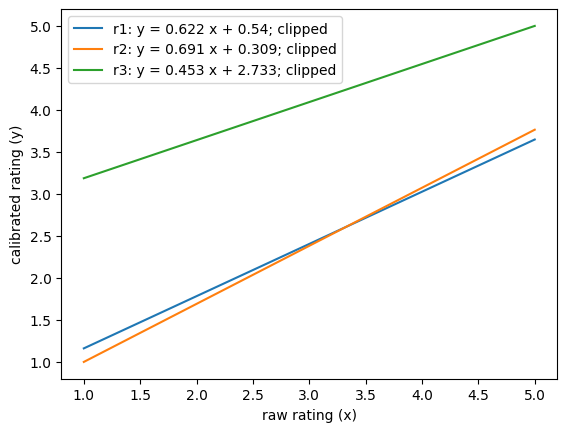

In [5]:
cp.rescale_parameters(data, bounds=(1, 5))

plt.figure()
plt.xlabel('raw rating (x)')
plt.ylabel('calibrated rating (y)')
for r in ('r1', 'r2', 'r3'):
    ar = round(cp.reviewer_scale(r), 3)
    br = round(cp.reviewer_offset(r), 3)
    plt.plot(
        xs, [cp.calibrate_rating(r, x, clip_endpoints=(1, 5)) for x in xs], 
        label=f"{r}: y = {ar} x + {br}; clipped"
    )
plt.legend()
plt.show()

Indeed, now all of the sudden, even a 5 star raw rating from reviewer 1 or 2 only results in a calibrated rating of < 4 stars. The reason for this is because `r3`'s 5 star rating after only ever rating with 1 and 2 stars is an extreme outlier. For this reason, one may desire to *ignore outliers* when rescaling parameters.

## Ignoring outliers when rescaling

`cp.rescale_parameters` takes in an optional argument `ignore_outliers`. If it is left to its default value, no outliers will be ignored when rescaling. On the other hand, if it is set to a float `f`, then all reviews that are `f` standard deviations away from the mean rating will be considered outliers and ignored when rescaling. Let's do this with `f = 2`.

In [6]:
cp.rescale_parameters(data, bounds=(1, 5), ignore_outliers=2)

We can now plot the same plot as above with these newly rescaled parameters.

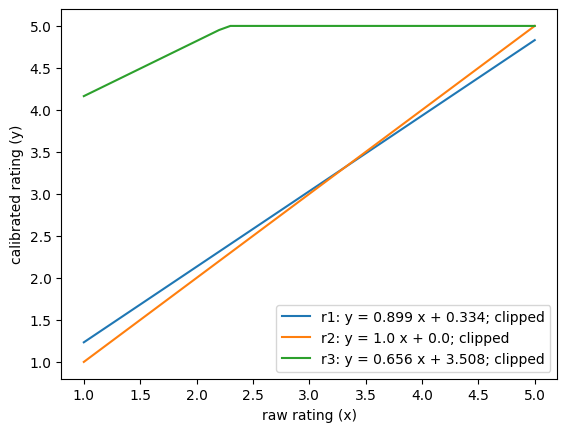

In [7]:
plt.figure()
plt.xlabel('raw rating (x)')
plt.ylabel('calibrated rating (y)')
for r in ('r1', 'r2', 'r3'):
    ar = round(cp.reviewer_scale(r), 3)
    br = round(cp.reviewer_offset(r), 3)
    plt.plot(
        xs, [cp.calibrate_rating(r, x, clip_endpoints=(1, 5)) for x in xs], 
        label=f"{r}: y = {ar} x + {br}; clipped"
    )
plt.legend()
plt.show()

We see that `r1` and `r2` are back to normal

## Conclusion

For the reason illustrated in this example, we generally recommend setting `ignore_outliers=f`, for some value of `f` between 2 and 3, when using the `rescale_parameters` method. However, note that by default, `f` is `inf`! Note also that if outliers are ignored, there may be ratings e.g. coming from the `calibrate_data` method that are not within the bounds. It follows that one may desire to call the `calibrate_data` method with the argument `clip_endpoints` supplied, as we did throughout this notebook.